# Desafío - Detección de cardiopatía

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
feature_names = pd.read_csv('/content/feature_names.csv', header=None).iloc[:,0].to_list()

In [ ]:
# Cargar nombres de columnas
feature_names = pd.read_csv("/content/feature_names.csv", header=None).squeeze().tolist()
print(feature_names)

['age', 'sex', 'cp', 'threstbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


In [ ]:
# Cargar cada archivo como DataFrame usando los nombres de columnas
cleveland = pd.read_csv("processed.cleveland.data", names=feature_names)
hungarian = pd.read_csv("processed.hungarian.data", names=feature_names)
switzerland = pd.read_csv("processed.switzerland.data", names=feature_names)

# Unir todos los datos
df = pd.concat([cleveland, hungarian, switzerland], ignore_index=True)
df

,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,70.0,1.0,4.0,115,0,0,1,92,1,0,2,?,7,1
716,70.0,1.0,4.0,140,0,1,0,157,1,2,2,?,7,3
717,72.0,1.0,3.0,160,0,?,2,114,0,1.6,2,2,?,0
718,73.0,0.0,3.0,160,0,0,1,121,0,0,1,?,3,1


Revisar y limpiar df

In [ ]:
# Verificar valores nulos o faltantes
print(df.isnull().sum())

# Algunas versiones de estos archivos pueden tener caracteres como "?" para valores faltantes
df.replace("?", pd.NA, inplace=True)

# Convertir columnas numéricas a tipo correcto (opcional pero recomendado)
df = df.apply(pd.to_numeric, errors='ignore')

# Convertir 'num' a binaria: 0 = sin enfermedad, >=1 = con enfermedad
df["num"] = df["num"].apply(lambda x: 1 if int(x) > 0 else 0)

age          0
sex          0
cp           0
threstbps    0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
num          0
dtype: int64


<ipython-input-7-df2d2155aaa7>:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [ ]:
# Reemplazar "?" por NA
df.replace("?", pd.NA, inplace=True)

In [ ]:
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        print(f"No se pudo convertir la columna {col}")

In [ ]:
print(df.dtypes)

age          float64
sex          float64
cp           float64
threstbps    float64
chol         float64
fbs          float64
restecg      float64
thalach      float64
exang        float64
oldpeak      float64
slope        float64
ca           float64
thal         float64
num            int64
dtype: object


Convertir la variable num a binaria (0 = sano, 1 = enfermedad)

In [ ]:
# Asegurarse de que sea numérica
df["num"] = pd.to_numeric(df["num"], errors="coerce")

# Transformar: 0 si es 0, 1 en otro caso
df["num"] = df["num"].apply(lambda x: 1 if x != 0 else 0)

Mostrar cantidad de valores ausentes por atributo

In [ ]:
# Convertir todas las columnas posibles a numéricas
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        print(f"No se pudo convertir {col}")

# Mostrar cantidad de valores ausentes
missing_counts = df.isna().sum()
print(missing_counts)

age            0
sex            0
cp             0
threstbps      3
chol          23
fbs           83
restecg        2
thalach        2
exang          2
oldpeak        6
slope        207
ca           413
thal         320
num            0
dtype: int64


Procesar los valores faltantes según los criterios

In [ ]:
# Criterio i: eliminar columnas con más de 25% de valores faltantes
threshold = 0.25
cols_to_drop = missing_counts[missing_counts > threshold * len(df)].index
df.drop(columns=cols_to_drop, inplace=True)
print(f"Columnas eliminadas: {list(cols_to_drop)}")

Columnas eliminadas: ['slope', 'ca', 'thal']


Criterio ii y iii: Rellenar por clase (num=0 y num=1)

In [ ]:
# Separar por clase
grouped = df.groupby("num")

# Para cada columna con valores faltantes restantes
for col in df.columns:
    if df[col].isna().sum() > 0 and col != "num":
        if df[col].dtype in [int, float]:  # Numéricas
            # Calcular promedio por clase
            means = grouped[col].mean()

            # Si es categórica (solo números enteros, ej. 'ca', 'thal'), redondear
            is_categorical = df[col].dropna().apply(float.is_integer).all()

            for clase in [0, 1]:
                fill_value = means[clase]
                if is_categorical:
                    fill_value = round(fill_value)

                df.loc[(df["num"] == clase) & (df[col].isna()), col] = fill_value

print("Valores faltantes restantes por columna:")
print(df.isna().sum())

Valores faltantes restantes por columna:
age          0
sex          0
cp           0
threstbps    0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
num          0
dtype: int64


Identificar variables discretas con ≥ 3 categorías

In [ ]:
# Excluir la variable objetivo
features = df.drop(columns=["num"])

# Contar cantidad de categorías únicas por columna
unique_vals = features.nunique()

# Filtrar aquellas con 3 o más categorías (potenciales discretas)
discrete_cols = unique_vals[unique_vals >= 3].index.tolist()

print("Variables discretas con 3 o más categorías:")
print(discrete_cols)

Variables discretas con 3 o más categorías:
['age', 'cp', 'threstbps', 'chol', 'restecg', 'thalach', 'oldpeak']


no todas las variables son discretas, por ejemplo age es continua, cp segun la descripcion del enunciado es el tipo de dolor torácico tiene 4 niveles esta la podriamos tomar como discreta, trestbps es continua ya que representa las presiones arteriales, del mismo modo chol es continua porque representa los valores de colesterol, restecg es categorica con 3 niveles, thalach es continua porque representa las frecuencias cardiacas y oldpeck es continua

In [ ]:
# Elegimos solo las variables categóricas discretas válidas
categorical_discrete_cols = ['cp']  # Agrega aquí 'slope' o 'thal' si aún están presentes

# Crear variables dummies (drop_first=True evita colinealidad)
df_dummies = pd.get_dummies(df, columns=categorical_discrete_cols, drop_first=True)

# Verificar resultado
print("Columnas después de aplicar dummies:")
print(df_dummies.columns)

Columnas después de aplicar dummies:
Index(['age', 'sex', 'threstbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'num', 'cp_2.0', 'cp_3.0', 'cp_4.0'],
      dtype='object')


cp_2.0, cp_3.0, cp_4.0 son las variables dummies generadas para los valores 2, 3 y 4 de cp.

La categoría base (eliminada por drop_first=True) es cp=1. Esto evita colinealidad.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Evitar problemas con estilo visual
sns.set(style="whitegrid")

# Copia del DataFrame
df_eda = df_dummies.copy()

# Excluimos la variable objetivo
features = df_eda.drop(columns=["num"])

# Identificamos continuas y categóricas (según tipo y número de valores únicos)
continuous_vars = [col for col in features.columns if df_eda[col].nunique() > 10 and df_eda[col].dtype != "object"]
categorical_vars = [col for col in features.columns if col not in continuous_vars]

print("Variables continuas:", continuous_vars)
print("Variables categóricas:", categorical_vars)

Variables continuas: ['age', 'threstbps', 'chol', 'thalach', 'oldpeak']
Variables categóricas: ['sex', 'fbs', 'restecg', 'exang', 'cp_2.0', 'cp_3.0', 'cp_4.0']


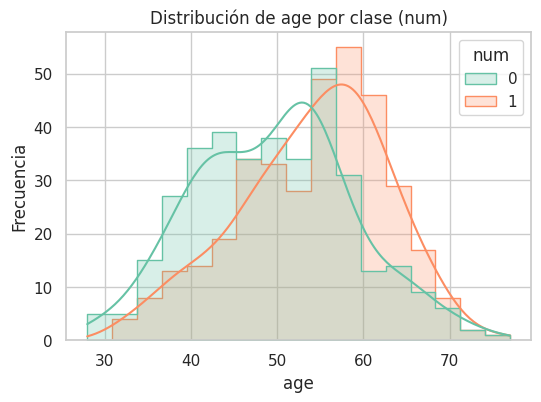

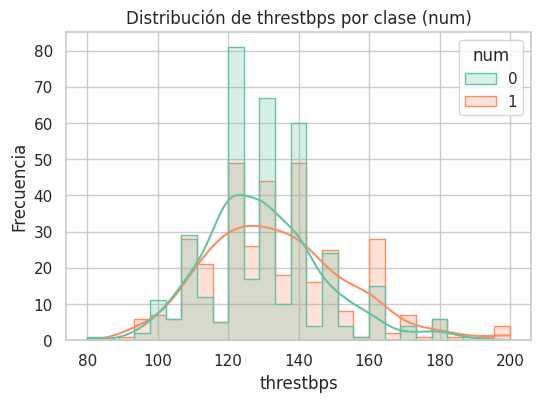

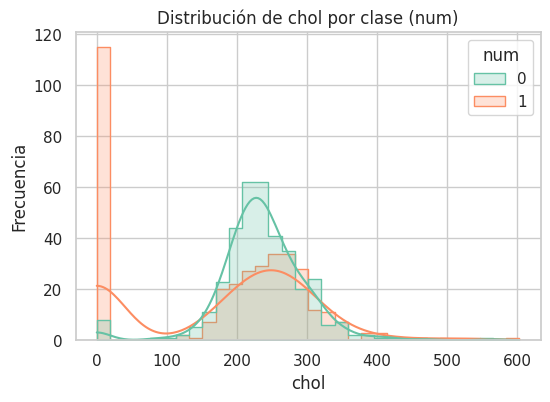

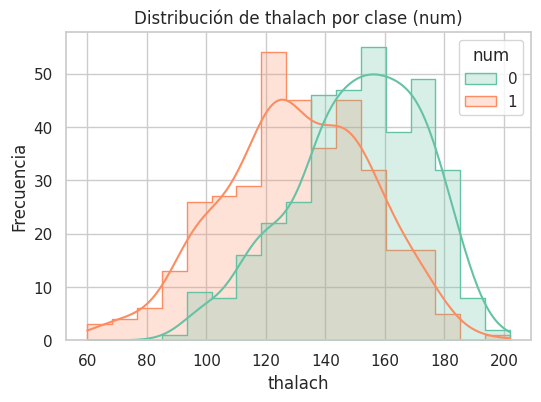

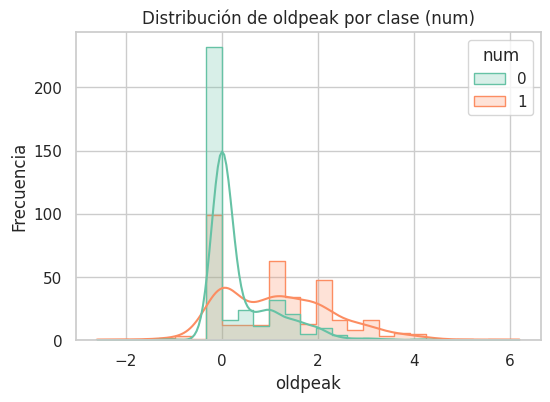

In [ ]:
# Histogramas de variables continuas
for col in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_eda, x=col, hue="num", kde=True, element="step", palette="Set2")
    plt.title(f"Distribución de {col} por clase (num)")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

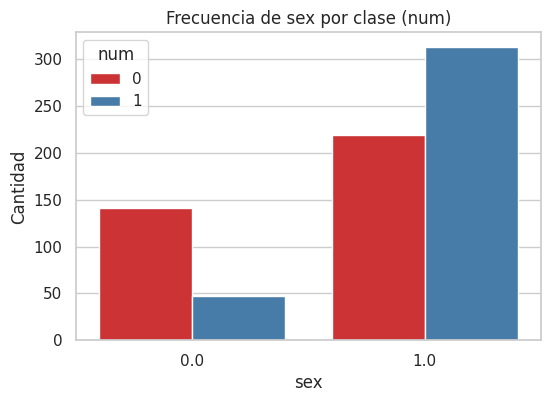

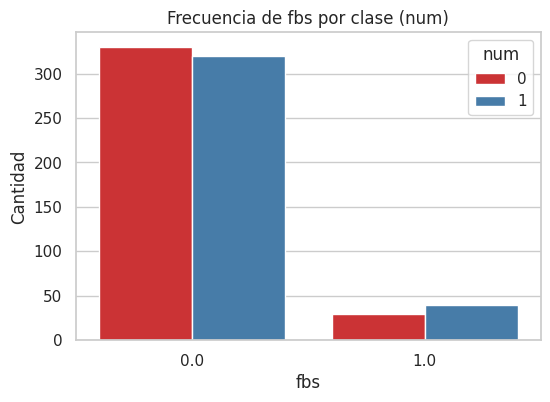

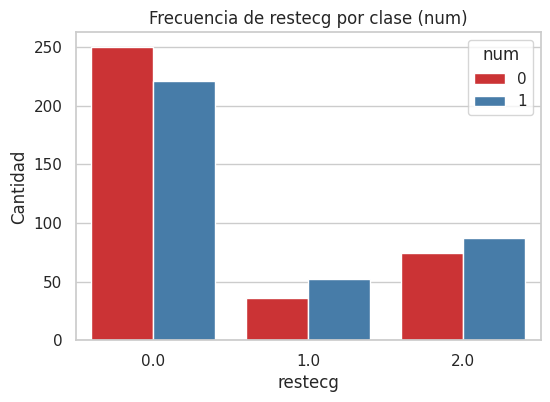

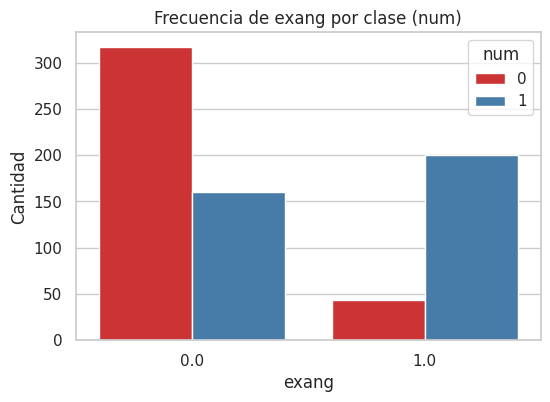

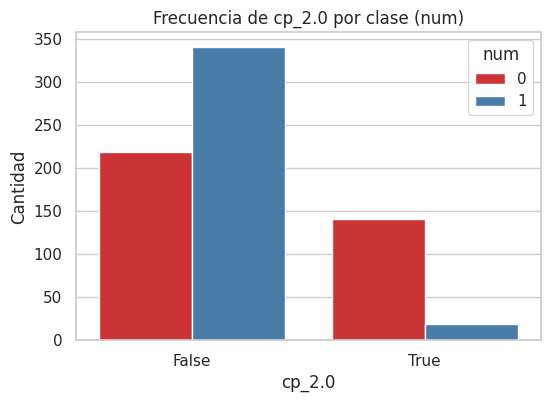

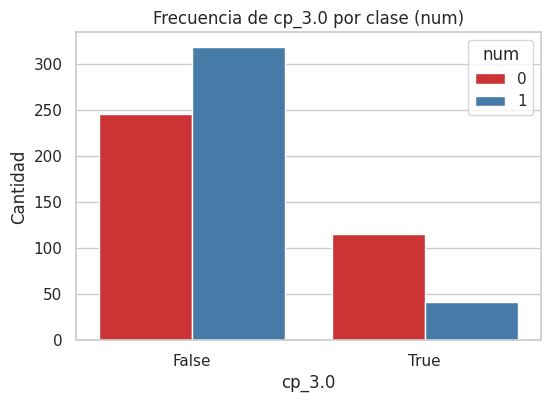

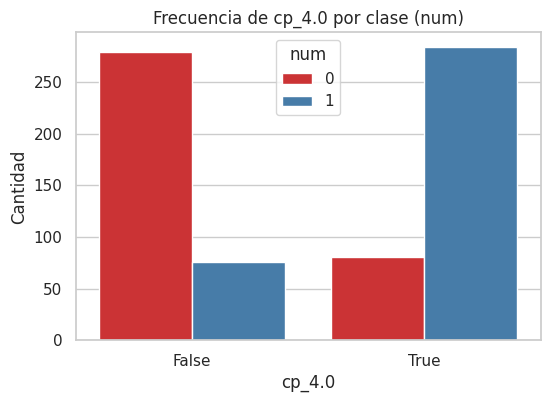

In [ ]:
# Gráficos de barras para categóricas
for col in categorical_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_eda, x=col, hue="num", palette="Set1")
    plt.title(f"Frecuencia de {col} por clase (num)")
    plt.xlabel(col)
    plt.ylabel("Cantidad")
    plt.show()

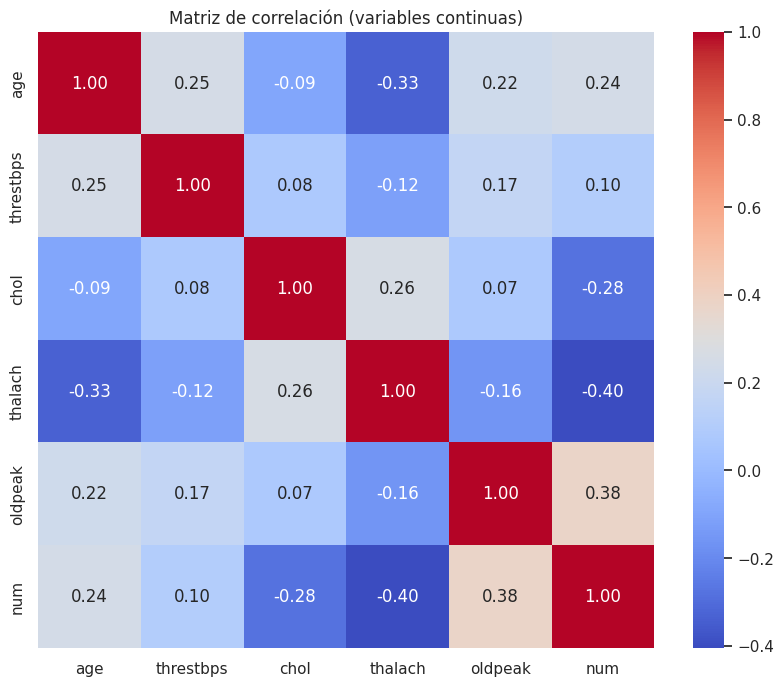

In [ ]:
# Matriz de correlaciones
corr_matrix = df_eda[continuous_vars + ["num"]].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación (variables continuas)")
plt.show()

Edad (age) muestra una ligera concentración entre los 50 y 60 años, especialmente en pacientes con enfermedad.

Presión arterial (threstbps) y colesterol (chol) están más dispersos, con valores extremos en pacientes enfermos.

Frecuencia cardíaca máxima (thalach) tiende a ser mayor en personas sin enfermedad.

cp (tipo de dolor torácico) muestra una relación clara con la clase: el dolor asintomático (cp_4.0) es más común en pacientes con enfermedad.

Las dummies de cp parecen estar correlacionadas con la variable objetivo.

La correlación más fuerte negativa con num es thalach (frecuencia cardíaca máxima), lo que sugiere que a mayor frecuencia alcanzada, menor probabilidad de enfermedad.

La variable oldpeak muestra correlación positiva moderada con num.

Algunas variables muestran diferencias claras entre clases (como cp, thalach, y oldpeak). Estas podrían ser útiles para predecir la presencia de cardiopatía. El análisis sugiere que un modelo de clasificación tiene potencial para discriminar correctamente entre pacientes con y sin enfermedad usando estas variables.

# 2. Divide la muestra en entrenamiento y test (33%),

In [ ]:
#Division de datos
from sklearn.model_selection import train_test_split

# Separar variable objetivo y features
X = df_dummies.drop(columns="num")
y = df_dummies["num"]

# Dividir en entrenamiento (67%) y test (33%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

=== AdaBoost ===
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       119
           1       0.82      0.82      0.82       119

    accuracy                           0.82       238
   macro avg       0.82      0.82      0.82       238
weighted avg       0.82      0.82      0.82       238

AUC: 0.9040322011157403


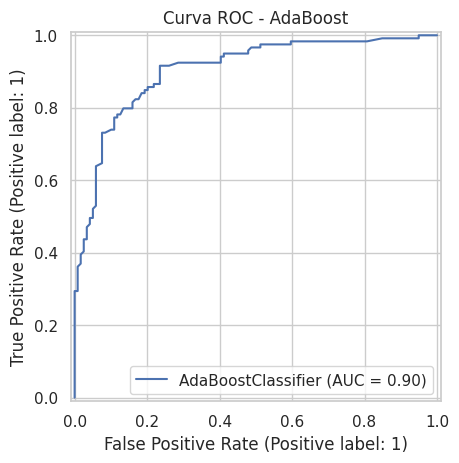

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
y_proba_ada = ada.predict_proba(X_test)[:,1]

print("=== AdaBoost ===")
print(classification_report(y_test, y_pred_ada))
print("AUC:", roc_auc_score(y_test, y_proba_ada))

RocCurveDisplay.from_estimator(ada, X_test, y_test)
plt.title("Curva ROC - AdaBoost")
plt.show()

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       119
           1       0.80      0.83      0.82       119

    accuracy                           0.82       238
   macro avg       0.82      0.82      0.82       238
weighted avg       0.82      0.82      0.82       238

AUC: 0.8819998587670361


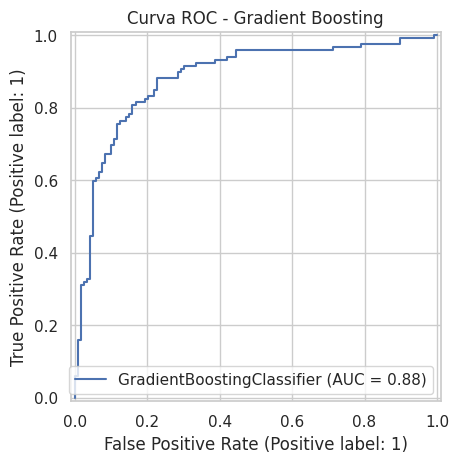

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:,1]

print("=== Gradient Boosting ===")
print(classification_report(y_test, y_pred_gb))
print("AUC:", roc_auc_score(y_test, y_proba_gb))

RocCurveDisplay.from_estimator(gb, X_test, y_test)
plt.title("Curva ROC - Gradient Boosting")
plt.show()

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       119
           1       0.78      0.84      0.81       119

    accuracy                           0.80       238
   macro avg       0.80      0.80      0.80       238
weighted avg       0.80      0.80      0.80       238

AUC: 0.875008827060236


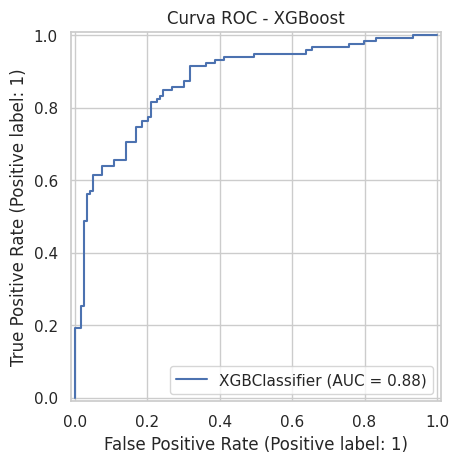

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))

RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("Curva ROC - XGBoost")
plt.show()

AdaBoost lidera en AUC (0.904), que es una métrica importante para evaluar capacidad discriminativa.

Los tres modelos tienen una exactitud (accuracy) similar (80-82%), con pequeñas diferencias.

AdaBoost y Gradient Boosting tienen métricas muy parejas; XGBoost se queda un poco atrás en accuracy y F1.

Las diferencias no son grandes, pero AdaBoost destaca levemente en este dataset.



# Realiza una búsqueda del hiper parámetro

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Definimos el modelo base
gb = GradientBoostingClassifier(random_state=42)

# Creamos la grilla de parámetros
param_grid = {
    'n_estimators': list(range(20, 201, int((200-20)/14))),  # 15 valores entre 20 y 200
    'learning_rate': list(np.linspace(0.004, 1.0, 40)),       # 40 valores entre 0.004 y 1.0
    'subsample': list(np.linspace(0.1, 1.0, 18))              # 18 valores entre 0.1 y 1.0
}

# Definimos GridSearch con validación cruzada
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid,
                           scoring='f1', cv=5, n_jobs=-1, verbose=2)

# Entrenamos con los datos de entrenamiento (suponiendo X_train, y_train)
grid_search.fit(X_train, y_train)

# Mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Entrenamos modelo con los mejores parámetros
best_gb = grid_search.best_estimator_

# Evaluamos en test
y_pred = best_gb.predict(X_test)
y_proba = best_gb.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

Fitting 5 folds for each of 11520 candidates, totalling 57600 fits
Mejores parámetros encontrados: {'learning_rate': np.float64(0.1316923076923077), 'n_estimators': 116, 'subsample': np.float64(0.5764705882352941)}
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       119
           1       0.77      0.81      0.79       119

    accuracy                           0.79       238
   macro avg       0.79      0.79      0.79       238
weighted avg       0.79      0.79      0.79       238

AUC: 0.8818586258032624


El modelo optimizado con GradientBoostingClassifier muestra un equilibrio sólido entre precisión y recall, alcanzando un F1-score de 0.79, que es competitivo respecto a los modelos iniciales.

El AUC de 0.882 indica una muy buena capacidad de discriminación del modelo.

La mejora obtenida respecto al modelo con parámetros por defecto justifica el uso de una búsqueda de hiperparámetros.

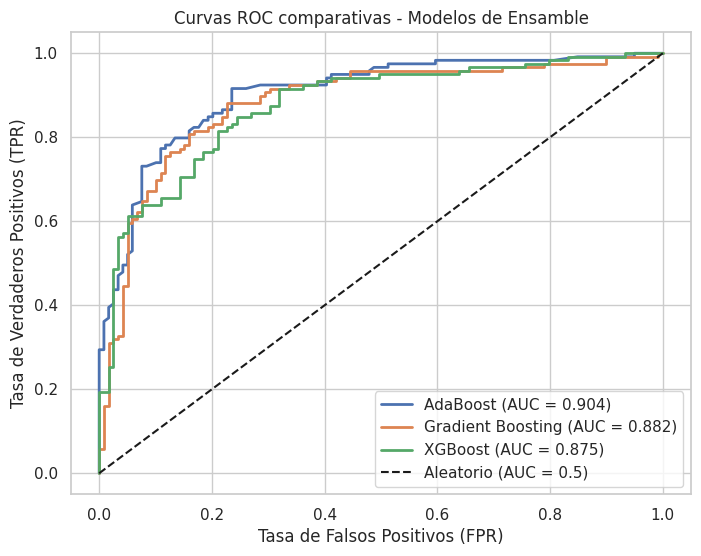

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular fpr, tpr y AUC para cada modelo
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_proba_ada)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

auc_ada = auc(fpr_ada, tpr_ada)
auc_gb = auc(fpr_gb, tpr_gb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost (AUC = {auc_ada:.3f})", linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {auc_gb:.3f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio (AUC = 0.5)")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC comparativas - Modelos de Ensamble")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

AdaBoost presenta una mejor área bajo la curva (AUC = 0.904), lo que indica una mayor capacidad de separar correctamente las clases positivas y negativas.

Gradient Boosting y XGBoost muestran un desempeño competitivo, pero con AUC ligeramente menores.

Esto confirma que AdaBoost es el modelo con mejor desempeño global en este caso, tanto por su f1-score balanceado, como por su capacidad discriminativa según el gráfico ROC.



# Importancia de las variables para el mejor modelo

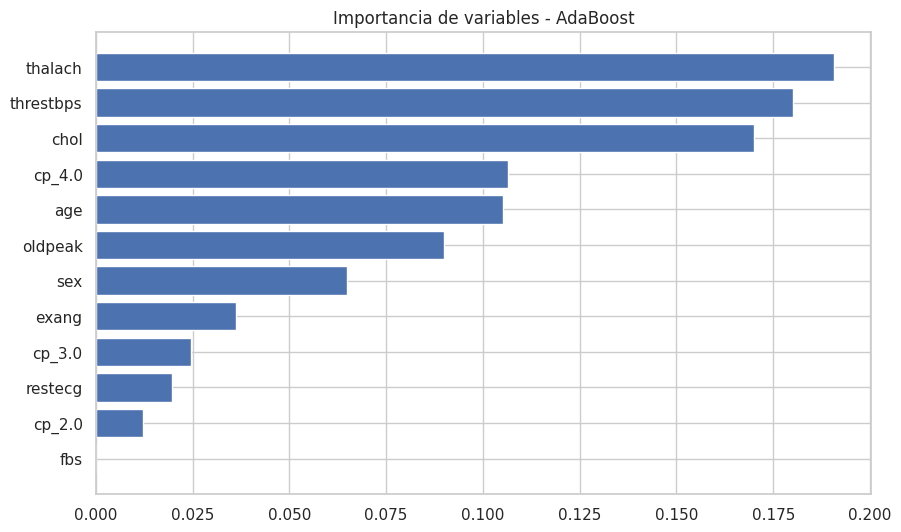

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = ada.feature_importances_
features = X_train.columns

df_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - AdaBoost")
plt.show()


In [ ]:
# Extraer importancias y nombres de las columnas
importances = ada.feature_importances_
features = X_train.columns

# Crear DataFrame con resultados
df_importances = pd.DataFrame({
    'Variable': features,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Mostrar
print(df_importances.head(3))

    Variable  Importancia
6    thalach     0.190672
2  threstbps     0.179990
3       chol     0.170125


thalach: Máxima frecuencia cardíaca alcanzada — es la variable con mayor peso en las decisiones del modelo. Esto sugiere que una mayor o menor frecuencia cardíaca máxima podría estar altamente relacionada con la presencia de enfermedad cardíaca.

threstbps: Presión arterial en reposo — segunda en importancia, lo cual es consistente con factores de riesgo clínico.

chol: Colesterol sérico — también altamente relevante, como es esperado en análisis cardiológicos.

